In [14]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
import random
from math import sin, cos, sqrt, atan2, radians
from ease_grid import EASE2_grid
grid_size = 36000
egrid = EASE2_grid(grid_size)
assert egrid.shape == (406, 964)
import time

In [15]:
# Set the size bins
max_diameter=330
diam_bins = [5, 10, 50, 100]
diam_labs = ['005', '005-009', '010-050', '050-100', '100+']
diam_range = {'005':[1,5],'005-009':[5,9],'010-050':[10,50],'050-100':[50,100],'100+':[100,max_diameter]}
lambda_start = {'005':1,'005-009':1.1,'010-050':1.2,'050-100':1.4,'100+':1.8}
lambda_end = {'005':2,'005-009':4,'010-050':8,'050-100':16,'100+':32}

In [16]:
# Make dictionary with size bins and frequency
with open('sfd.csv', 'r') as f:
    freqs = pd.read_csv(f).groupby('D').sum()
los_dict = {i:0 for i in diam_labs}
his_dict = {i:0 for i in diam_labs}
for i in freqs.index.values:
    for j in range(len(diam_bins)):
        if i < diam_bins[j]:
            los_dict[diam_labs[j]] += freqs.loc[i,'low']
            his_dict[diam_labs[j]] += freqs.loc[i,'high']
            break
        elif i >= diam_bins[-1]:
            los_dict[diam_labs[-1]] += freqs.loc[i,'low']
            his_dict[diam_labs[-1]] += freqs.loc[i,'high']
            break
df_freq = pd.DataFrame.from_dict({'high':his_dict, 'low':los_dict, 
                                  'lambda_start':lambda_start, 'lambda_end':lambda_end})
df_freq['frequency_factor'] = [0.1,0.2,0.3,0.6,0.8]
df_freq

,high,low,lambda_start,lambda_end,frequency_factor
005,16950000,1695000,1.0,2,0.1
005-009,855000,85500,1.1,4,0.2
010-050,146100,14610,1.2,8,0.3
050-100,8700,870,1.4,16,0.6
100+,3050,305,1.8,32,0.8


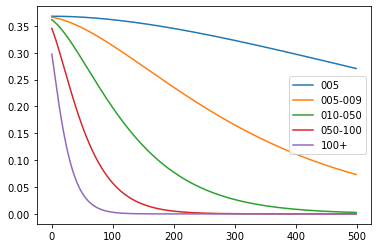

total impacts 5340328.0
impacts by diameter {'005': 4752872.0, '005-009': 565461.0, '010-050': 17859.0, '050-100': 2689.0, '100+': 1447.0}
fraction of total {'005': 0.89, '005-009': 0.11, '010-050': 0.0, '050-100': 0.0, '100+': 0.0}


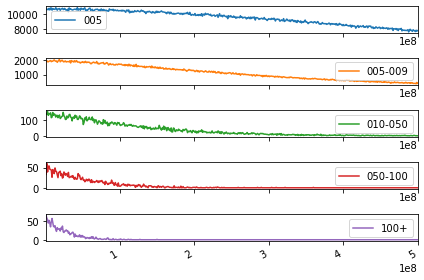

,high,low,lambda_start,lambda_end,frequency_factor,total
005,16950000,1695000,1.0,2,0.000035,4752872.0
005-009,855000,85500,1.1,4,0.000185,565461.0
010-050,146100,14610,1.2,8,0.002707,17859.0
050-100,8700,870,1.4,16,0.007701,2689.0
100+,3050,305,1.8,32,0.005391,1447.0


In [17]:
t_total=500

fivehundredmillion = 500000000
freq_factor = fivehundredmillion/t_total

not_converged=True
while not_converged:

    pp = {x:np.zeros(t_total) for x in diam_labs}
    l = {x:np.linspace(y,z,t_total) for x,y,z in zip(diam_labs,df_freq['lambda_start'],df_freq['lambda_end'])}

    for D in diam_labs:
        pp[D] = l[D]*np.exp(-l[D])

    df = pd.DataFrame(data=pp)
    hits = {d:np.zeros(t_total) for d in diam_labs}

    # Main loop through time. Calculate the total number of impacts of each diameter at each time step
    for t in range(0,t_total):
        for D in diam_labs:
            hits[D][t] = np.floor(np.random.poisson(pp[D][t] / df_freq.loc[D, 'frequency_factor']))


    total_sum = np.sum([hits[d] for d in diam_labs])
    sums = {d:np.sum(hits[d]) for d in diam_labs}
    frac = {d:np.round(np.sum(hits[d])/total_sum,2) for d in diam_labs}
    
    for d in diam_labs:
        df_freq.loc[d,'total']=sums[d]
    
    good_numbers = 0
    for d in diam_labs:
        if df_freq.loc[d,'total'] < df_freq.loc[d,'low']:
            df_freq.loc[d,'frequency_factor'] = df_freq.loc[d,'frequency_factor']*random.random()
        elif df_freq.loc[d,'total'] > df_freq.loc[d,'high']:
            df_freq.loc[d,'frequency_factor'] = df_freq.loc[d,'frequency_factor']*(1+random.random())
        else:
            good_numbers+=1
    if good_numbers == df_freq.shape[0]:
        not_converged = False
    
    
    
plt.plot(df)
plt.legend(df.columns.values)
plt.show()
print('total impacts', total_sum)
print('impacts by diameter', sums)
print('fraction of total', frac)
plot_time = np.linspace(0,fivehundredmillion,t_total+1)[1:]
df = pd.DataFrame(data=hits, index=plot_time)
df.plot(subplots=True)
plt.tight_layout()
plt.show()
df_freq

In [18]:
# approximate radius of earth in km
def distance(lat1,lat2,lon1,lon2):
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return(distance) #km

In [38]:
class IMPAaCS:

    """
    Update: May 29th 2021 @ 5PM Central Time, commenting out the code to use very small impactors.
    Update: May 29th 2021 @ 2:30PM Central Time, Search only the subset of grids for impact, else skip
    Update: May 28th 2021 @ 12:19PM Central Time, with Jordan to get ensembles running
    
    Dynamic geospatial model of IMPaCS, 
    using the size-frequency distribution of impacts scaled from the lunar surface, 
    we generate the volume and abundance of this enriched crust on Earth’s surface 
    during the Hadean to determine how rapidly it evolved.
    """
    
    impact_test_id = str(round(0.14122179,4))+' '+str(round(0.18672199,4))
    
    def __init__(self, egrid, 
                 verbose=False,
                 max_depth_of_impact_melt=330,
                 ensemble = 0,
                 primitive_initial_state=45,
                 fraction_upper_layer = 2/3,
                 target_SiO2 = 62.58,     # From sudbury
                 upper_SiO2 = 68.71,      # From sudbury
                 n_layers_impact_melt = 2,
                 z_discretized_km = int(2),
                 proportion_melt_from_impact = 1/3,
                 sim_time=0,
                 lon_lims = [-180, 180], lat_lims = [-45, 45]):
        self.egrid = egrid
        self.verbose=verbose
        self.ensemble=ensemble
        self.primitive_initial_state = primitive_initial_state
        self.max_depth_of_impact_melt = max_depth_of_impact_melt
        self.fraction_upper_layer = fraction_upper_layer        # d_upper / Mi (from Sudbury)
        self.fraction_lower_layer = 1-self.fraction_upper_layer # d_lower / Mi (from Sudbury)
        self.n_layers_impact_melt = n_layers_impact_melt
        self.target_SiO2 = target_SiO2 # From sudbury
        self.upper_SiO2 = upper_SiO2  # From sudbury
        self.z_discretized_km = z_discretized_km
        self.proportion_melt_from_impact = proportion_melt_from_impact
        self.average_target = self.primitive_initial_state
        self.average_target_list = [self.primitive_initial_state]
        self.top_layer_at_test_cell = [self.primitive_initial_state]
        self.average_test_target_list = [self.primitive_initial_state]
        self.n_x = self.egrid.londim.shape[0]
        self.n_y = self.egrid.latdim.shape[0]
        self.sim_time=sim_time
        
        self.count_test_hits = 0
        self.grid_cell_state = {}
        self.impacted_grid_cells = []
        self.impactors_at_test_cell = [0]
        self.test_time = [0]
                
        self.sample_percents = {}
        self.lon_lims=lon_lims
        self.lat_lims=lat_lims
        self.lon_subset=[]
        self.lat_subset=[]
        
        # Set up the grids so we don't search the whole planet for every impact
        self.get_subset_of_grids()
        self.n_x = len(self.lon_subset)
        self.n_y = len(self.lat_subset)
        
        # Finally we set up the state data
        self.state_prep()
        
    #--------------------------------------------------------------------------------------------------
    def update(self, impact_loc, impactor_diameter, sim_time=0):
        self.sim_time = sim_time
        self.impact_dimensions(impactor_diameter)
        self.find_the_grid(impact_loc)
        if len(self.impacted_grid_cells) > 0:
            self.get_average_target(impactor_diameter)
            self.loop_impact_grid(impactor_diameter)
        
    #--------------------------------------------------------------------------------------------------
    #---- THIS IS THE MAIN CODE -------------------- THIS IS THE MAIN CODE ----------------------------
    #--------------------------------------------------------------------------------------------------
    def state_dynamics(self, impactor_diameter, grid_cell_id):
        """
        This is the critical component of this model
        This function will change the chemical makeup of each grid cell
            according to the chemical theory put forward by Faltys-Wielicki [2021]
        """
        
        #####      DYNAMIC FACTORS       ############################
        depth_of_impact_melt = impactor_diameter * self.proportion_melt_from_impact # D/3

        #Vertical discretization.
        melt_layers = int(depth_of_impact_melt / self.z_discretized_km)

        lower_layer  = range(int(round(self.fraction_upper_layer * melt_layers,2)), melt_layers)
        upper_layer  = range(0, int(round(self.fraction_upper_layer * melt_layers,2)))

        fracionated_melt = depth_of_impact_melt * self.fraction_upper_layer #Units: km

        fractionation_factor = 1 - (self.target_SiO2 / self.upper_SiO2)

        #####      DO THE DYANMICS       #############################
        # Set lower layer to primitive initial state.  
        for i in lower_layer:
            self.grid_cell_state[grid_cell_id][i] = self.primitive_initial_state

        # Impact melt portion  (Upper)
        for i in upper_layer:
            self.grid_cell_state[grid_cell_id][i] = self.average_target / (1 - fractionation_factor)

        # Weighted average of upper    
        wt_sio2_upper = self.grid_cell_state[grid_cell_id][0]

        # Lower of impact melt portion
        for i in lower_layer:
            numerator = self.average_target-(self.fraction_upper_layer * wt_sio2_upper)
            self.grid_cell_state[grid_cell_id][i] = numerator / self.fraction_lower_layer

        for i in range(melt_layers):
            self.grid_cell_state[grid_cell_id][i] = np.round(self.grid_cell_state[grid_cell_id][i],1)
    
    #--------------------------------------------------------------------------------------------------    
    def state_prep(self):
        total_layers = int(self.max_depth_of_impact_melt / self.z_discretized_km)
        for ilon in self.lon_subset:
            for ilat in self.lat_subset:
                grid_cell_id = str(round(ilon,4))+' '+str(round(ilat,4))
                self.grid_cell_state[grid_cell_id] = np.ones(total_layers) * self.primitive_initial_state
        
    #--------------------------------------------------------------------------------------------------    
    def get_average_target(self, impactor_diameter):
        average_target = 0
        for grid_cell in self.impacted_grid_cells:
            grid_cell_id = str(round(grid_cell[0],4))+' '+str(round(grid_cell[1],4))
            ### If the grid cell has not been hit yet, it is the initial primitive value
            if grid_cell_id in self.grid_cell_state.keys():
                average_target += np.sum(self.grid_cell_state[grid_cell_id][:self.z_layers])
            else:
                average_target += self.primitive_initial_state * self.z_layers
        self.average_target = average_target/(len(self.impacted_grid_cells) * self.z_layers)
        
    #--------------------------------------------------------------------------------------------------    
    def find_the_grid(self, impact_loc):
        self.impacted_grid_cells = [] # first reset the impacted grid cells, then fill them up
        Dmin=10000000
        for ilon in self.lon_subset:
            for ilat in self.lat_subset:
                D = distance(impact_loc[0],ilat,impact_loc[1],ilon)
                if D < Dmin:
                    Dmin = D
                if D <= self.crator_radius:
                    self.impacted_grid_cells.append([ilon, ilat])
#         if len(self.impacted_grid_cells) < 1:
            
#             # If the crator didn't impact any grids in the subsample, 
#             # Check to see if the min distance is smaller than the length of a grid.
#             # If it is, we can assign it to the closest grid.
#             # If not, then just ignore it.
#             if Dmin < 30:
#                 if self.verbose:
#                     print("Warning. There are no grids impacted!")
#                     print('Dmin', Dmin, 'crator radius', self.crator_radius, 'impact location', impact_loc)
#                 for ilon in self.lon_subset:
#                     for ilat in self.lat_subset:
#                         D = distance(impact_loc[0],ilat,impact_loc[1],ilon)
#                         if D == Dmin:
#                             self.impacted_grid_cells.append([ilon, ilat])
#                             if self.verbose:
#                                 print('impacting grid cell', [ilon, ilat])

    #--------------------------------------------------------------------------------------------------    
    def loop_impact_grid(self, impactor_diameter):
        for grid_cell in self.impacted_grid_cells:
            grid_cell_id = str(round(grid_cell[0],4))+' '+str(round(grid_cell[1],4))

            ################      DO THE DYANMICS       #############################
            self.state_dynamics(impactor_diameter, grid_cell_id)

            self.test_one_grid_cell(grid_cell_id, impactor_diameter)
    #--------------------------------------------------------------------------------------------------    
    def impact_dimensions(self, impactor_diameter):
            # The impact crator is 10*Diameter, so the radius is half that
            self.crator_diameter = 10*impactor_diameter
            self.crator_radius = self.crator_diameter/2
            self.z_layers = int(np.ceil(impactor_diameter / self.z_discretized_km))

    #--------------------------------------------------------------------------------------------------    
    def test_one_grid_cell(self, grid_cell_id, impactor_diameter):
        ##### Testing one cell:
        if grid_cell_id == self.impact_test_id:
            self.count_test_hits+=1
            self.test_time.append(self.sim_time)
            self.impactors_at_test_cell.append(impactor_diameter)
            self.average_test_target_list.append(self.average_target)
            self.top_layer_at_test_cell.append(self.grid_cell_state[self.impact_test_id][0])

    #--------------------------------------------------------------------------------------------------
    def re_bin_sio2(self, temp_state, s_min=34, s_max=70, ds=1):
        """
            Functionto place the mean SiO2 into the proper bin for distribution.
        """
        for s in range(s_min,s_max,ds):
            if temp_state<=s:
                return s
            elif temp_state>=s_max:
                return s_max
            else:
                continue

    # ---------------------------------------------------------------------------------------------
    def plot_map_and_bar(self, save_figure=False, plot_figure=False, fig_path='./'):
        
        """
            Function for plotting 2D map of SiO2 States.
            Function inputs:
                save_figure=False
                plot_figure=False
                fig_path='./'
        """
        
        if not plot_figure and not save_figure:
            print('not plotting figure')
            return

        z = np.zeros([self.n_x, self.n_y])
        bar_list = []
        for i, ilon in enumerate(self.lon_subset):
            for j, ilat in enumerate(self.lat_subset):
                grid_cell = str(round(ilon,4))+' '+str(round(ilat,4))
                temp_state = np.mean(self.grid_cell_state[grid_cell][0:2])
                temp_state = self.re_bin_sio2(temp_state)
                z[i, j] = temp_state
        
        X, Y = np.meshgrid(self.lon_subset, self.lat_subset)
        
        fig = plt.figure(figsize=(12, 7))

        grid = plt.GridSpec(1, 7, wspace = .1, hspace = .1)
        plt.subplots_adjust(wspace= 0.1, hspace= 0.1)

        plt.subplot(grid[0, :5])
        
        levels = np.arange(34, 70, 2)
        cmap = cm.jet
        cs = plt.contourf(X, Y, np.transpose(z), levels, cmap=cm.get_cmap(cmap, len(levels) - 1)) 
        cbar = fig.colorbar(cs, ticks=range(34,70,2))

        plt.title('Surface SiO2 content at {}myr'.format(int(self.sim_time/1000000)))
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.xlim(self.lon_lims)
        plt.ylim(self.lat_lims)
        plt.xticks(np.arange(self.lon_lims[0], self.lat_lims[1], 10))
        
        plt.subplot(grid[0, 5:])
        plt.bar(list(self.sample_percents.keys()), list(self.sample_percents.values()), width=1.2)
        plt.xlim([35,70])
        plt.ylim([0,40])
        plt.xlabel('Surface SiO2 content')
        plt.ylabel('Percent surface area')
        plt.xticks(np.arange(35, 75, 5))
        if save_figure:
            plt.savefig(fig_path+'{}myr.png'.format(int(self.sim_time/1000000)), 
                    bbox_inches='tight', dpi = 100)
        if plot_figure:
            plt.show()
        plt.close()
        
    # ---------------------------------------------------------------------------------------------
    def do_sample_percents(self, n_layers=2):
        
        """
            Function Summarizing and saving SiO2 percentages in a sample region.
            Function inputs:
                plot_x_lims = Limits of longitude for SiO2 sample
                plot_y_lims = Limits of latitude for SiO2 sample
                n_layers = number of discretized layers to include in the average.
        """
        
        z = np.zeros([self.n_x, self.n_y])
        bar_list = []
        for i, ilon in enumerate(self.lon_subset):
            for j, ilat in enumerate(self.lat_subset):
                grid_cell = str(round(ilon,4))+' '+str(round(ilat,4))
                temp_state = np.mean(self.grid_cell_state[grid_cell][0:2])
                temp_state = self.re_bin_sio2(temp_state)
                z[i, j] = temp_state
                
                mean_sio2 = np.mean(self.grid_cell_state[grid_cell][0:2])
                if not np.isnan(mean_sio2):
                    bar_list.append(self.re_bin_sio2(mean_sio2))
        
        bar_list = [x for x in bar_list if x != None]
        
        bar_data = {}
        for u in np.unique(bar_list):
            bar_data[u] = 100*bar_list.count(u)/len(bar_list)

        self.sample_percents = bar_data
        
    # ---------------------------------------------------------------------------------------------
    def get_subset_of_grids(self):
        for ilon in self.egrid.londim:
            for ilat in self.egrid.latdim:
                if ilat > self.lat_lims[0] and ilat < self.lat_lims[1]:
                    if ilon > self.lon_lims[0] and ilon < self.lon_lims[1]:
                        if ilat not in self.lat_subset:
                            self.lat_subset.append(ilat)
                        if ilon not in self.lon_subset:
                            self.lon_subset.append(ilon)


In [39]:
list_impacts_export = list(range(0,500,50))
list_impacts_export.append(499)

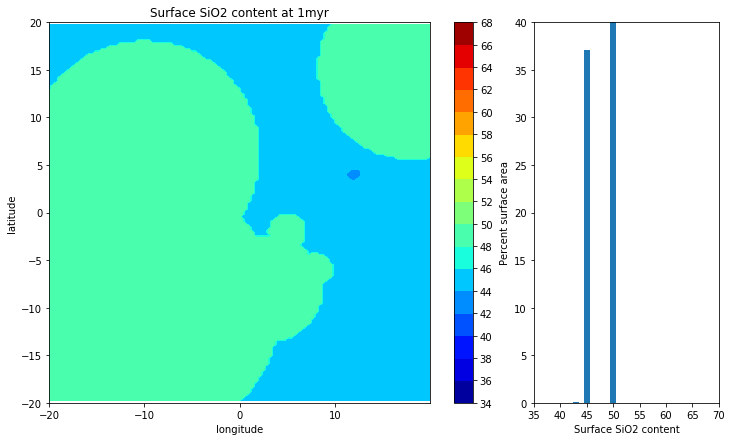

43     0.087225
45    37.043747
50    62.869028
Name: 0, dtype: float64


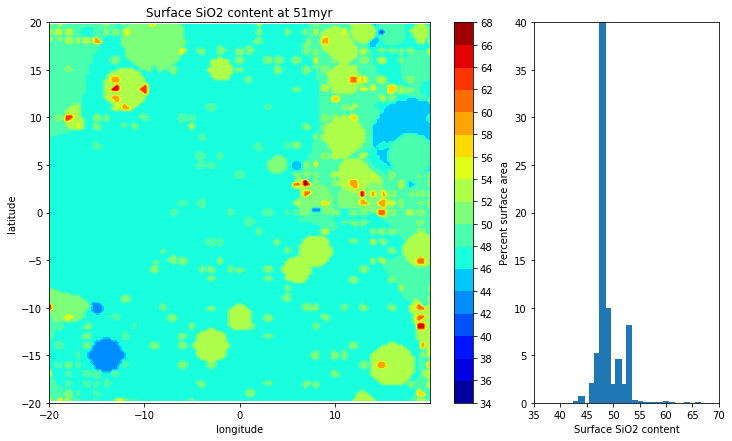

43     0.174450
45          NaN
50     2.006173
47     5.233494
54     0.328771
55     0.154321
48    63.848631
49     9.916801
51     4.589372
53     8.219270
57     0.100644
58     0.073806
59     0.093935
52     2.006173
60     0.154321
64     0.060386
46     2.053140
56     0.053677
61     0.134192
62     0.026838
70          NaN
44     0.670961
41          NaN
42     0.026838
38          NaN
66     0.060386
69     0.013419
Name: 50, dtype: float64


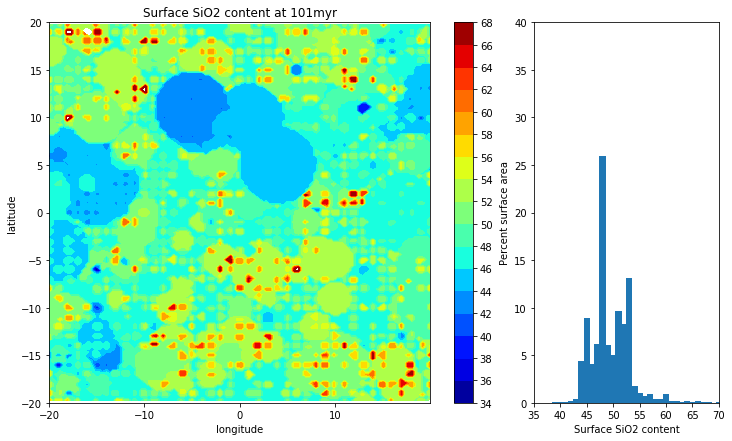

43     0.449634
45     8.932286
50     5.066774
47     6.221059
54     1.811959
55     0.986511
48    25.931146
49     6.080129
51     9.610093
53    13.133347
57     0.879136
58     0.375814
59     0.395947
52     8.294745
60     0.966378
64     0.167774
46     4.066841
56     0.704651
61     0.167774
62     0.194618
70     0.114086
44     4.402389
41     0.087242
42     0.221462
38          NaN
66     0.181196
69     0.006711
68     0.120797
67     0.107375
65     0.053688
63     0.107375
39     0.033555
40     0.107375
35     0.020133
Name: 100, dtype: float64


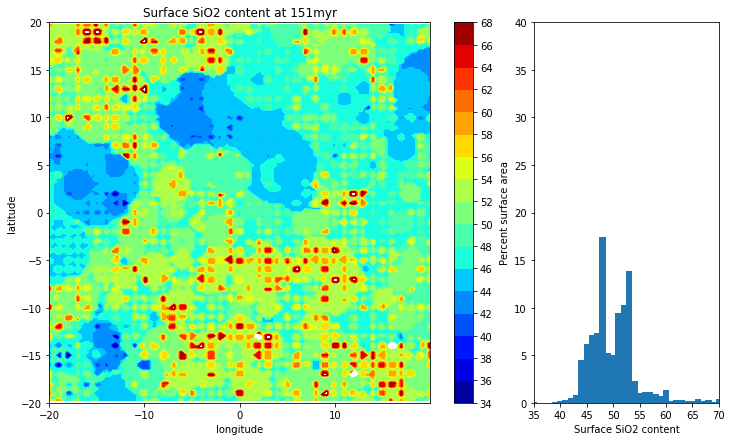

43     0.845978
45     6.150128
50     5.055727
47     7.351954
54     2.329797
55     0.986975
48    17.476836
49     5.270579
51     9.473614
53    13.904928
57     1.101115
58     0.906405
59     0.684840
52    10.239022
60     1.396536
64     0.234994
46     7.090103
56     1.114543
61     0.208138
62     0.295421
70     0.382704
44     4.511884
41     0.335706
42     0.550557
38     0.013428
66     0.436417
69     0.100712
68     0.342420
67     0.147710
65     0.241708
63     0.288707
39     0.134282
40     0.228280
35     0.053713
36     0.026856
37     0.013428
34     0.073855
Name: 150, dtype: float64


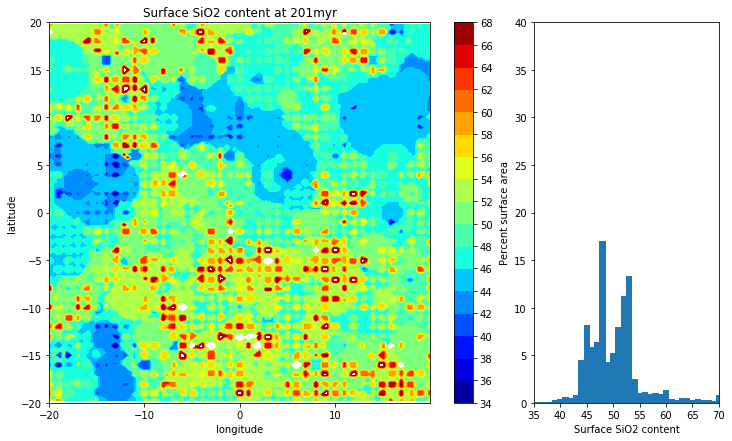

43     0.820996
45     8.169583
50     5.215343
47     6.359354
54     2.456258
55     1.069987
48    16.998654
49     4.333782
51     7.987887
53    13.351279
57     0.962315
58     1.063257
59     0.915209
52    11.197847
60     1.312248
64     0.477793
46     5.861373
56     1.157470
61     0.403769
62     0.316285
70     0.814266
44     4.528937
41     0.578735
42     0.538358
38     0.067295
66     0.423957
69     0.188425
68     0.242261
67     0.309556
65     0.289367
63     0.497981
39     0.262450
40     0.423957
35     0.060565
36     0.134590
37     0.060565
34     0.148048
Name: 200, dtype: float64


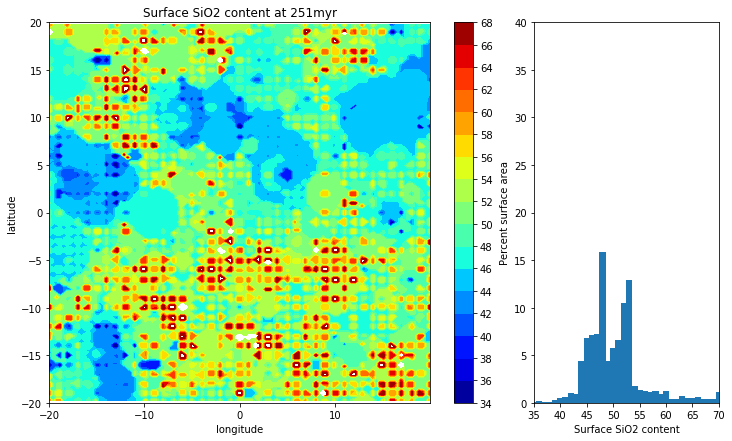

43     0.894539
45     6.786387
50     5.784235
47     7.284100
54     1.782351
55     1.378800
48    15.852838
49     4.351628
51     6.577885
53    12.873285
57     1.183750
58     1.237557
59     0.901264
52    10.478881
60     1.217380
64     0.504439
46     7.163035
56     1.203928
61     0.396825
62     0.450632
70     1.136669
44     4.412160
41     0.618779
42     1.029056
38     0.053807
66     0.645682
69     0.390100
68     0.356470
67     0.443906
65     0.497713
63     0.692763
39     0.309389
40     0.470810
35     0.060533
36     0.147969
37     0.047081
34     0.383374
Name: 250, dtype: float64


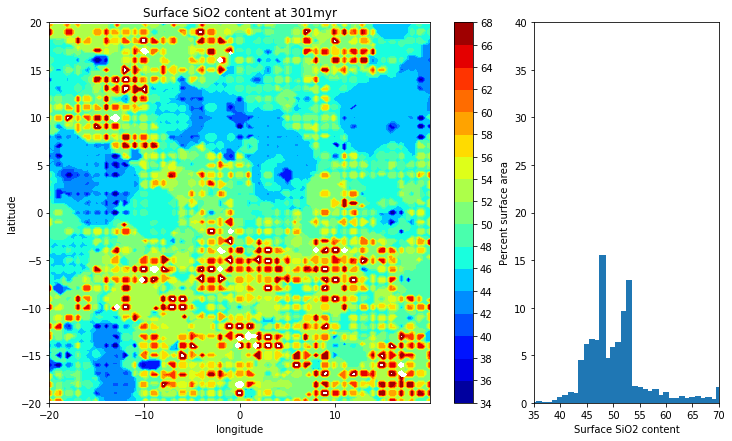

43     1.050151
45     6.173006
50     5.822955
47     6.637496
54     1.730057
55     1.642545
48    15.530125
49     4.665096
51     6.442275
53    12.924941
57     1.231908
58     1.480983
59     0.794345
52     9.666779
60     1.171323
64     0.457758
46     6.691350
56     1.467519
61     0.464490
62     0.477954
70     1.629081
44     4.496802
41     0.774150
42     1.104005
38     0.107708
66     0.760687
69     0.376977
68     0.578930
67     0.471222
65     0.599125
63     0.700101
39     0.296197
40     0.605857
35     0.040390
36     0.168294
37     0.100976
34     0.666442
Name: 300, dtype: float64


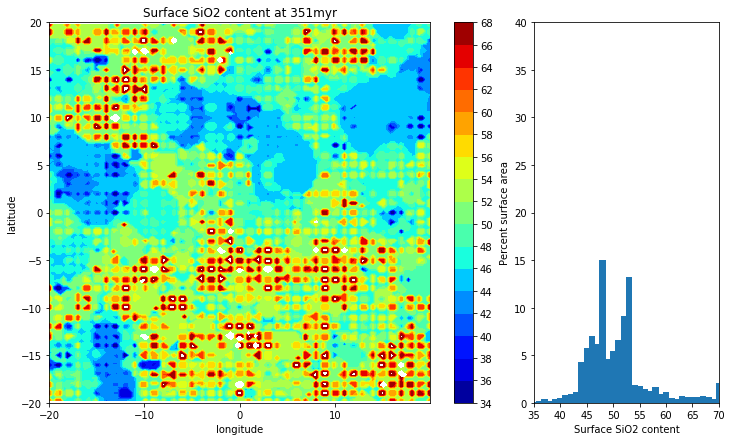

43     1.091424
45     5.787240
50     5.470592
47     6.204945
54     1.859462
55     1.731456
48    14.970020
49     4.648656
51     6.595702
53    13.204878
57     1.219430
58     1.637135
59     0.896045
52     9.088459
60     1.131847
64     0.646770
46     7.060567
56     1.482180
61     0.552449
62     0.444654
70     2.048103
44     4.298322
41     0.821936
42     0.956680
38     0.215590
66     0.633295
69     0.370545
68     0.626558
67     0.741090
65     0.606346
63     0.666981
39     0.350333
40     0.512026
35     0.080846
36     0.148218
37     0.350333
34     0.848885
Name: 350, dtype: float64


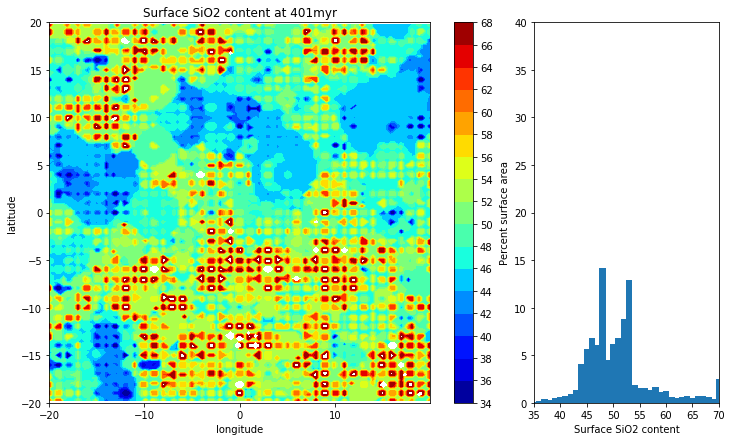

43     1.353353
45     5.649071
50     6.187719
47     6.120388
54     1.858336
55     1.548613
48    14.146243
49     4.484245
51     6.827363
53    12.873687
57     1.333154
58     1.663076
59     1.124428
52     8.806895
60     1.252357
64     0.693509
46     6.861029
56     1.582278
61     0.619445
62     0.498249
70     2.457581
44     4.039860
41     0.733908
42     0.915702
38     0.242392
66     0.733908
69     0.444385
68     0.585780
67     0.720442
65     0.518449
63     0.558847
39     0.464584
40     0.592513
35     0.060598
36     0.175061
37     0.403986
34     0.868570
Name: 400, dtype: float64


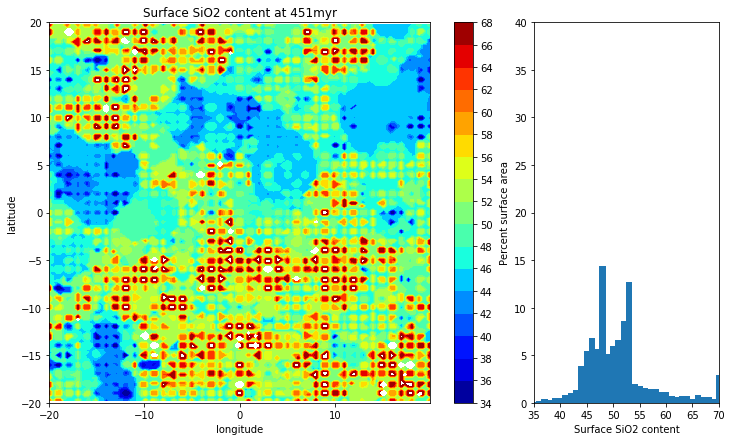

43     1.328568
45     5.449150
50     5.927974
47     5.705422
54     1.969247
55     1.719719
48    14.364715
49     5.125438
51     6.575398
53    12.665228
57     1.422984
58     1.490424
59     1.166712
52     8.578365
60     1.119504
64     0.708120
46     6.784462
56     1.524144
61     0.687888
62     0.640680
70     2.933639
44     3.864311
41     0.768816
42     0.977880
38     0.256272
66     0.789048
69     0.431616
68     0.620448
67     0.654168
65     0.418128
63     0.674400
39     0.472080
40     0.546264
35     0.101160
36     0.161856
37     0.397896
34     0.977880
Name: 450, dtype: float64


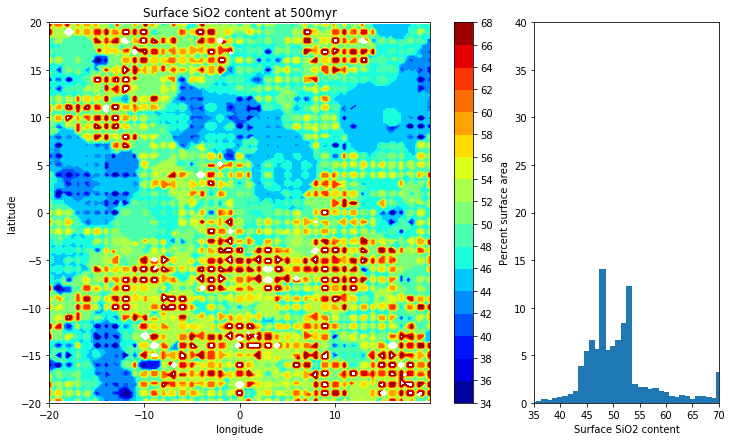

43     1.268128
45     5.436762
50     5.976391
47     5.679595
54     1.935919
55     1.686341
48    14.111298
49     5.537943
51     6.549747
53    12.283305
57     1.436762
58     1.558179
59     1.200675
52     8.404722
60     1.112985
64     0.667791
46     6.650927
56     1.632378
61     0.728499
62     0.634064
70     3.217538
44     3.878583
41     0.708263
42     0.937605
38     0.256324
66     0.721754
69     0.492411
68     0.593592
67     0.674536
65     0.397976
63     0.822934
39     0.499157
40     0.580101
35     0.121417
36     0.202361
37     0.364250
34     1.038786
Name: 499, dtype: float64


In [40]:
impact_boundz=20
[-impact_boundz, impact_boundz]
Impc = IMPAaCS(egrid, max_depth_of_impact_melt=330, 
               lon_lims = [-impact_boundz, impact_boundz], lat_lims = [-impact_boundz, impact_boundz])
# Loop through impacts, the df has them stored by time and diameter bn
for it, t in enumerate(df.index.values):
    start_time = time.time()
    for d in diam_labs:
        for i in range(int(df.loc[t,d])):

            # locate the the impacts on earth
            impact_lat = random.randrange(-90,90)
            impact_lon = random.randrange(-180,180)
            if np.abs(impact_lat) > impact_boundz:
                continue
            if np.abs(impact_lon) > impact_boundz:
                continue
            impact_loc = [impact_lat, impact_lon]
            impactor_diameter = random.randrange(diam_range[d][0],diam_range[d][1])
                
            #####      DO THE DYANMICS       #############################
            Impc.update(impact_loc, impactor_diameter, t)
            
    Impc.do_sample_percents(n_layers=2)
    
    if it == 0:
        percent_df = pd.DataFrame(Impc.sample_percents, index=[it])
    else:
        percent_df = percent_df.append(Impc.sample_percents, ignore_index=True)
            
    # make a map of the results at this time
    if it in list_impacts_export:
        Impc.plot_map_and_bar(plot_figure=True)
        print(percent_df.iloc[-1,:])

In [ ]:
plt.plot(Impc.test_time, Impc.average_test_target_list)
plt.plot(Impc.test_time, Impc.top_layer_at_test_cell)
plt.legend(["average target", "top layer, single cell"])
plt.xlabel("time")
plt.ylabel("SiO2")
plt.show()
plt.close()
plt.scatter(Impc.test_time, Impc.impactors_at_test_cell)
plt.ylabel("impact diameter")
plt.xlabel("time")
plt.show()
plt.close()

In [ ]:
n_x = egrid.londim.shape[0]
n_y = egrid.latdim.shape[0]
z = np.zeros([n_x, n_y])
for i, ilon in enumerate(egrid.londim):
    for j, ilat in enumerate(egrid.latdim):
        grid_cell = str(round(ilon,4))+' '+str(round(ilat,4))
        z[i, j] = np.mean(Impc.grid_cell_state[grid_cell][0:2])

X, Y = np.meshgrid(egrid.londim, egrid.latdim)

In [ ]:
z

In [ ]:
# fig1, ax1 = plt.subplots(constrained_layout=True)
# fig1.clim(30, 65)
# cs = ax1.contourf(X, Y, np.transpose(z), vmin=30, vmax=65)
# cs.set_clim(30, 65)
# fig1.colorbar(cs)
# cbar = fig1.colorbar(cs, boundaries=[30,65], cmap = cs)
# cbar.ax.set_ylabel('percent SiO2')
#cbar.set_clim(30,65)
plt.contourf(X, Y, np.transpose(z), vmin=30, vmax=65)
plt.clim(vmin=30, vmax=65)
cb = plt.colorbar()
cb.set_clim(vmin=30, vmax=65)
plt.title('top 6-meter sio2 at time {}myr'.format(int(Impc.sim_time/1000000)))
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()
plt.close()

In [ ]:
### This is only a test. I am forcing impacts at one location to test the dynamics
### This is only a test. I am forcing impacts at one location to test the dynamics
### This is only a test. I am forcing impacts at one location to test the dynamics
print("This is only a test. I am forcing impacts at one location to test the dynamics")
print("This is only a test. I am forcing impacts at one location to test the dynamics")
I = IMPAaCS(egrid)
I.__init__(egrid)
impact_test_diameters = [330, 73, 16, 10, 5, 2, 330, 73, 16, 10, 5, 2]
# Loop through impacts, the df has them stored by time and diameter bn
for it, t in enumerate(df.index.values):
    print('time', it)
    for d in diam_labs[3:]:
        for i in range(int(df.loc[t,d])):

            # locate the the impacts on earth
            impact_lat = random.randrange(-90,90)
            impact_lon = random.randrange(-180,180)
            impact_loc = [impact_lat, impact_lon]

            # Specify the diameter within the bin
            if it < len(impact_test_diameters):                  # Test scenario
                impactor_diameter = impact_test_diameters[it]    # Test scenario
                impact_lat = 33.2921                             # Test scenario
                impact_lon = -87.5726                            # Test scenario
                impact_loc = [impact_lat, impact_lon]            # Test scenario
            else:                                                # Test scenario
                impactor_diameter = random.randrange(diam_range[d][0],diam_range[d][1])
                
            #####      DO THE DYANMICS       #############################
            I.update(impact_loc, impactor_diameter, t)

            break  # Test scenario

        if it < len(impact_test_diameters):   # Test scenario
            print("This is only a test. I am forcing impacts at one location to test the dynamics")
            print('{} diameter IMPAaC at Test cell: {}'.format(impactor_diameter, 
                                                               I.impact_test_id))
            print('average_target: {}, across {} grid cells'.format(np.round(I.average_target,1), 
                                                            len(I.impacted_grid_cells)))
            print("SiO2 states:")
            print(list(I.grid_cell_state[I.impact_test_id])[0:75])
            print(" ")
        break  # Test scenario

    if it > len(impact_test_diameters):  # Test scenario
        break  # Test scenario

In [ ]:
plt.plot(I.test_time, I.average_test_target_list)
plt.plot(I.test_time, I.top_layer_at_test_cell)
plt.legend(["average target", "top layer, single cell"])
plt.xlabel("time")
plt.ylabel("SiO2")
plt.show()
plt.close()
plt.scatter(I.test_time, I.impactors_at_test_cell)
plt.ylabel("impact diameter")
plt.xlabel("time")
plt.show()
plt.close()

# 10 X impacts teste cast

In [ ]:
### This is only a test. I am forcing impacts at one location to test the dynamics
### This is only a test. I am forcing impacts at one location to test the dynamics
### This is only a test. I am forcing impacts at one location to test the dynamics
print("This is only a test. I am forcing impacts at one location to test the dynamics")
print("This is only a test. I am forcing impacts at one location to test the dynamics")
I = IMPAaCS(egrid)
I.__init__(egrid)
impact_test_diameters = [330, 330, 330, 330, 330, 330, 330, 330, 330, 330,
                         73, 73, 73, 73, 73, 73, 73, 73, 73, 73,
                         16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 
                         10, 10,  10,  10,  10,  10,  10,  10,  10,  10, 
                         5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                         2, 2, 2, 2, 2, 2, 2, 2, 2, 2,]
# Loop through impacts, the df has them stored by time and diameter bn
for it, t in enumerate(df.index.values):
    print('time', it)
    for d in diam_labs[3:]:
        for i in range(int(df.loc[t,d])):

            # locate the the impacts on earth
            impact_lat = random.randrange(-90,90)
            impact_lon = random.randrange(-180,180)
            impact_loc = [impact_lat, impact_lon]

            # Specify the diameter within the bin
            if it < len(impact_test_diameters):                  # Test scenario
                impactor_diameter = impact_test_diameters[it]    # Test scenario
                impact_lat = 33.2921                             # Test scenario
                impact_lon = -87.5726                            # Test scenario
                impact_loc = [impact_lat, impact_lon]            # Test scenario
            else:                                                # Test scenario
                impactor_diameter = random.randrange(diam_range[d][0],diam_range[d][1])
                
            #####      DO THE DYANMICS       #############################
            I.update(impact_loc, impactor_diameter, t)

            break  # Test scenario

        if it < len(impact_test_diameters):   # Test scenario
            print("This is only a test. I am forcing impacts at one location to test the dynamics")
            print('{} diameter IMPAaC at Test cell: {}'.format(impactor_diameter, 
                                                               I.impact_test_id))
            print('average_target: {}, across {} grid cells'.format(np.round(I.average_target,1), 
                                                            len(I.impacted_grid_cells)))
            print("SiO2 states:")
            print(list(I.grid_cell_state[I.impact_test_id])[0:75])
            print(" ")
        break  # Test scenario

    if it > len(impact_test_diameters):  # Test scenario
        break  # Test scenario

In [ ]:
plt.plot(I.test_time, I.average_test_target_list)
plt.plot(I.test_time, I.top_layer_at_test_cell)
plt.legend(["average target", "top layer, single cell"])
plt.xlabel("time")
plt.ylabel("SiO2")
plt.show()
plt.close()
plt.scatter(I.test_time, I.impactors_at_test_cell)
plt.ylabel("impact diameter")
plt.xlabel("time")
plt.show()
plt.close()